# Wellington Data Analysis

_Author_: Darshan Mehta

The purpose of this notebook is to perform an investigatory analysis of the Wellington Dataset ([link](http://lila.science/datasets/wellingtoncameratraps)) CSV metadata file (present [here](https://lilablobssc.blob.core.windows.net/wellingtoncameratraps/wellington_camera_traps.csv.zip)) to identify, understand and possibly modify the information present in the file.

In [13]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
# Read the file
file_path = os.path.join(os.getcwd(), '..', 'data', 'wellington_camera_traps.csv')

raw_data = pd.read_csv(file_path)

In [3]:
# Print some demo top rows
raw_data.head()

,sequence,image_sequence,file,label,site,date,camera
0,2,image1,290716114012001a1116.jpg,BIRD,001a,7/29/2016 11:40,111
1,12,image1,100816090812001a1111.jpg,BIRD,001a,8/10/2016 9:08,111
2,17,image1,180516121622001a1602.jpg,BIRD,001a,5/18/2016 12:16,160
3,18,image1,260416120224001a1601.jpg,BIRD,001a,4/26/2016 12:02,160
4,20,image1,160516023810001a1606.jpg,CAT,001a,5/16/2016 2:38,160


The dataset webpage says that there are 270,450 images from 187 camera locations in the dataset. Each of the 90,150 sequences contain 3 images taken as part of the burst imagery. Each sequence is classified into 15 animal categories, empty, and unclassifiable. Approximately 17% of images are labeled as empty. Let us verify this dataset to make sure we are not missing any part of it.

In [4]:
print("There are", len(raw_data), "images in the dataset.")

There are 270450 images in the dataset.


In [5]:
print("There are", len(raw_data.camera.unique()), "unique camera locations in the dataset.")

There are 129 unique camera locations in the dataset.


Hmmm... $\large{🐟}$. I'm not sure how useful it is to have the right camera locations for our problem statement right now, but it is good that we have found and documented the issue so that we can trace back if we face a problem in the future.

In [6]:
print("There are", len(raw_data.label.unique()), "unique labels in the dataset.")

There are 17 unique labels in the dataset.


In [7]:
print("There are", len(raw_data.sequence.unique()), "unique sequences in the dataset.")

There are 90478 unique sequences in the dataset.


Hmmmm.. extra $\huge{🐟}$. This means that not every sequence has 3 images. Let's see what are we facing here. 

In [8]:
unique_image_counts = raw_data.groupby('sequence')["image_sequence"].transform("count").unique()
print("There various unique counts of images in sequences are:", unique_image_counts)

There various unique counts of images in sequences are: [3 2 1]


Interesting $\large{🤔}$. Let's dive deeper to see what kind of sequences these are that don't have 3 images.

In [9]:
raw_data['sequence_image_count'] = raw_data.groupby('sequence')["image_sequence"].transform("count")
print('There are a total of', sum(raw_data.sequence_image_count < 3), 'sequences with less than 3 images.')
raw_data[raw_data.sequence_image_count < 3].head()

There are a total of 837 sequences with less than 3 images.


,sequence,image_sequence,file,label,site,date,camera,sequence_image_count
726,1201,image1,190616143858005as131.jpg,BIRD,005a,6/19/2016 14:38,s13,2
1030,1681,image1,200416105138008as231.jpg,BIRD,008a,4/20/2016 10:51,s23,2
2493,4177,image1,260616045024017c5901.jpg,CAT,017c,6/26/2016 4:50,590,2
3604,5997,image1,260616225616030cs512.jpg,CAT,030c,6/26/2016 22:56,s51,2
5197,8617,image1,080816075142037b3101.jpg,BIRD,037b,8/8/2016 7:51,310,2


These seem to be very normal sequences with nothing peculiar about them. For the sake of simplicity, let us discard all such sequences. Let's also discard the rows where the label is `UNCLASSIFIABLE` since we have no idea what those are. 

In [16]:
invalid_rows = (raw_data.label == 'UNCLASSIFIABLE') | (raw_data.sequence_image_count < 3)
filtered_data = raw_data[~invalid_rows]

In [17]:
len(filtered_data[filtered_data.label == 'NOTHINGHERE']) / len(filtered_data)

0.17107591726314603

Since for our problem, we want to first learn to classify if a frame has animal or not, let's create a new binary label.

In [18]:
filtered_data['has_animal'] = (filtered_data.label != 'NOTHINGHERE').astype(int)
filtered_data.head()

/Users/Darshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal
0,2,image1,290716114012001a1116.jpg,BIRD,001a,7/29/2016 11:40,111,3,1
1,12,image1,100816090812001a1111.jpg,BIRD,001a,8/10/2016 9:08,111,3,1
2,17,image1,180516121622001a1602.jpg,BIRD,001a,5/18/2016 12:16,160,3,1
3,18,image1,260416120224001a1601.jpg,BIRD,001a,4/26/2016 12:02,160,3,1
4,20,image1,160516023810001a1606.jpg,CAT,001a,5/16/2016 2:38,160,3,1


Now, let us create a column where we would mention if a given sequence belongs to the training, vaidation or the testing set. We will write a function such that it would allot sequences to these sets with probability 70:15:15 for train, val and test sets.

In [28]:
def get_set_mapping(values):
    random_nums = np.random.uniform(0, 1, values.shape[0])
    mapping = {}
    for value, random_num in zip(values, random_nums):
        if random_num < 0.7:
            mapping[value] = 'train'
        elif random_num < 0.85:
            mapping[value] = 'val'
        else:
            mapping[value] = 'test'
    return mapping

In [29]:
set_mapping = get_set_mapping(filtered_data.sequence.unique())
filtered_data['set'] = filtered_data.sequence.map(set_mapping.get)
filtered_data.head()

/Users/Darshan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal,set
0,2,image1,290716114012001a1116.jpg,BIRD,001a,7/29/2016 11:40,111,3,1,train
1,12,image1,100816090812001a1111.jpg,BIRD,001a,8/10/2016 9:08,111,3,1,train
2,17,image1,180516121622001a1602.jpg,BIRD,001a,5/18/2016 12:16,160,3,1,train
3,18,image1,260416120224001a1601.jpg,BIRD,001a,4/26/2016 12:02,160,3,1,train
4,20,image1,160516023810001a1606.jpg,CAT,001a,5/16/2016 2:38,160,3,1,test


Now, let us save this file to disk as `final_dataset.csv`.

In [34]:
output_filepath = os.path.join(os.getcwd(), '..', 'data', 'final_dataset.csv')
filtered_data.to_csv(output_filepath, index=False)

Now, when working with Tensorflow Datasets, in order to speed up, we need to restructure our dataset and create 3 files, one each for train, test and val. Each row in this file would correspond to a sequence number and would have the label and path to all the three images from the burst.

In [91]:
def get_pivoted_subset(data, subset):
    subset_data = data.loc[data.set == subset]
    pivoted_data = subset_data.pivot(index='sequence', 
                                     columns='image_sequence', 
                                     values='file').reset_index()
    pivoted_data.columns.name = None
    label_mapper = data[['sequence', 'has_animal']].drop_duplicates('sequence')\
                   .set_index('sequence').to_dict()['has_animal']
    pivoted_data['has_animal'] = pivoted_data.sequence.map(label_mapper.get)
    return pivoted_data

Here's a demo of what the output of the above function would be like:

In [92]:
get_pivoted_subset(filtered_data, 'train').head()

,sequence,image1,image2,image3,has_animal
0,2,290716114012001a1116.jpg,290716114014001a1114.jpg,290716114014001a1115.jpg,1
1,3,280716130614001a1111.jpg,280716130614001a1112.jpg,280716130614001a1113.jpg,0
2,4,280716130526001a1113.jpg,280716130528001a1111.jpg,280716130528001a1112.jpg,0
3,5,250716162756001a1113.jpg,250716162758001a1111.jpg,250716162758001a1112.jpg,0
4,6,250716130638001a1113.jpg,250716130640001a1111.jpg,250716130640001a1112.jpg,0


In [93]:
# Train set
output_filepath_train = os.path.join(os.getcwd(), '..', 'data', 'final_dataset_train.csv')
get_pivoted_subset(filtered_data, 'train').to_csv(output_filepath_train, index=False)

# Validation set
output_filepath_val = os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val.csv')
get_pivoted_subset(filtered_data, 'val').to_csv(output_filepath_val, index=False)

# Test set
output_filepath_test = os.path.join(os.getcwd(), '..', 'data', 'final_dataset_test.csv')
get_pivoted_subset(filtered_data, 'test').to_csv(output_filepath_test, index=False)

## Species Classification

In [10]:
final_data = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'final_dataset.csv'))

In [11]:
final_data.head()

,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal,set
0,2,image1,290716114012001a1116.JPG,BIRD,001a,7/29/2016 11:40,111,3,1,train
1,12,image1,100816090812001a1111.JPG,BIRD,001a,8/10/2016 9:08,111,3,1,train
2,17,image1,180516121622001a1602.JPG,BIRD,001a,5/18/2016 12:16,160,3,1,train
3,18,image1,260416120224001a1601.JPG,BIRD,001a,4/26/2016 12:02,160,3,1,train
4,20,image1,160516023810001a1606.JPG,CAT,001a,5/16/2016 2:38,160,3,1,test


In [21]:
final_data.label.value_counts()

BIRD           154203
NOTHINGHERE     45531
CAT             30117
HEDGEHOG        10647
MOUSE            6477
RABBIT           5688
POSSUM           4326
Ship rat         3183
RAT              2745
DOG               987
Norway rat        861
GOAT              645
DEER              309
HARE              207
PIG               192
MUSTELID           27
Name: label, dtype: int64

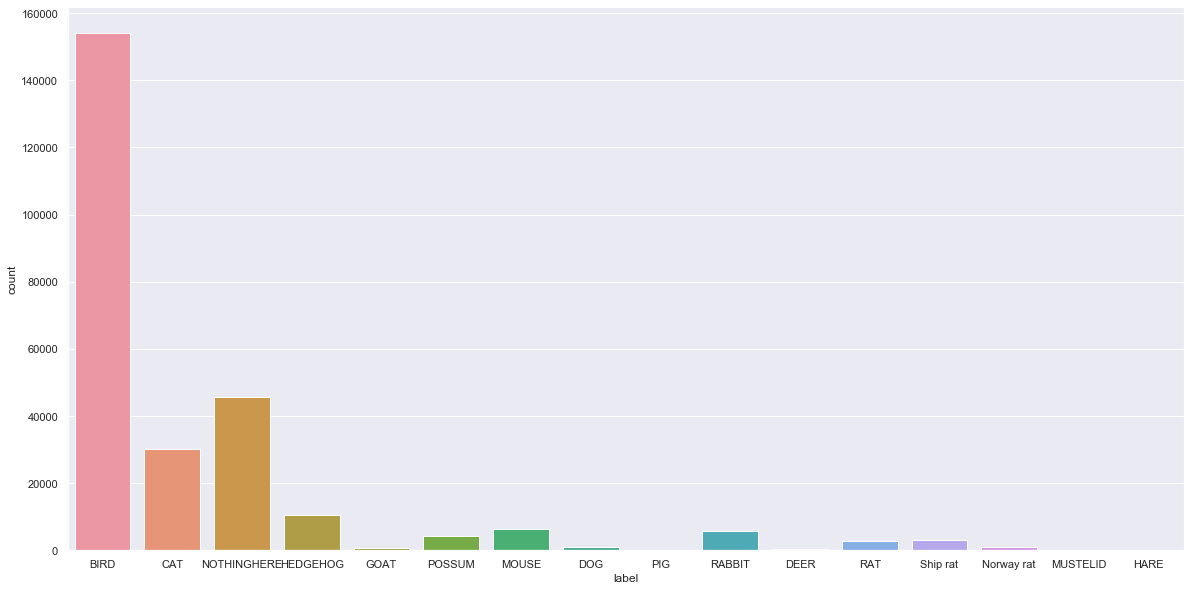

In [18]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.countplot(final_data.label)

In [7]:
labels = set(final_data.label.unique())
label_mapper = {label: idx for idx, label in enumerate(labels)}
print(label_mapper)

{'BIRD': 0, 'CAT': 1, 'RAT': 2, 'MOUSE': 3, 'Norway rat': 4, 'DOG': 5, 'POSSUM': 6, 'PIG': 7, 'Ship rat': 8, 'MUSTELID': 9, 'RABBIT': 10, 'DEER': 11, 'NOTHINGHERE': 12, 'HARE': 13, 'HEDGEHOG': 14, 'GOAT': 15}


In [8]:
final_data['label'] = final_data.label.replace(label_mapper)
final_data.head()

,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal,set
0,2,image1,290716114012001a1116.JPG,0,001a,7/29/2016 11:40,111,3,1,train
1,12,image1,100816090812001a1111.JPG,0,001a,8/10/2016 9:08,111,3,1,train
2,17,image1,180516121622001a1602.JPG,0,001a,5/18/2016 12:16,160,3,1,train
3,18,image1,260416120224001a1601.JPG,0,001a,4/26/2016 12:02,160,3,1,train
4,20,image1,160516023810001a1606.JPG,1,001a,5/16/2016 2:38,160,3,1,test


In [9]:
def get_pivoted_subset(data, subset):
    subset_data = data.loc[data.set == subset]
    pivoted_data = subset_data.pivot(index='sequence', 
                                     columns='image_sequence', 
                                     values='file').reset_index()
    pivoted_data.columns.name = None
    label_mapper = data[['sequence', 'label']].drop_duplicates('sequence')\
                   .set_index('sequence').to_dict()['label']
    pivoted_data['label'] = pivoted_data.sequence.map(label_mapper.get)
    return pivoted_data

In [ ]:
# Train set
output_filepath_train = os.path.join(os.getcwd(), '..', 'data', 'final_dataset_train.csv')
get_pivoted_subset(filtered_data, 'train').to_csv(output_filepath_train, index=False)

# Validation set
output_filepath_val = os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val.csv')
get_pivoted_subset(filtered_data, 'val').to_csv(output_filepath_val, index=False)

# Test set
output_filepath_test = os.path.join(os.getcwd(), '..', 'data', 'final_dataset_test.csv')
get_pivoted_subset(filtered_data, 'test').to_csv(output_filepath_test, index=False)

In [19]:
final_data.sample(5)

,sequence,image_sequence,file,label,site,date,camera,sequence_image_count,has_animal,set
264870,66983,image3,2703151508000235S133.JPG,NOTHINGHERE,235,3/27/2015 15:08,S13,3,0,train
171261,50166,image2,300116061602023b3302.JPG,RABBIT,023b,1/30/2016 6:16,330,3,1,val
104920,38086,image2,261215070304029a3302.JPG,BIRD,029a,12/26/2015 7:03,330,3,1,train
254358,68309,image3,2706152354440267L036.JPG,POSSUM,267,6/27/2015 23:54,L03,3,1,train
93656,8246,image2,220116155436031a2541.JPG,BIRD,031a,1/22/2016 15:54,254,3,1,train
